## Import

In [1]:
import os
import cv2

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check

Current cuda device  0


In [3]:
import random

In [4]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

fix_all_seeds(37)

In [5]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

#os.chdir('/content/gdrive/MyDrive/sw_ai')

## Utils

In [5]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [6]:
train_img_dir = './pro_data/data_for_training_and_testing/train/images/'
train_mask_dir = './pro_data/data_for_training_and_testing/train/masks/'

valid_img_dir = './pro_data/data_for_training_and_testing/val/images/'
valid_mask_dir = './pro_data/data_for_training_and_testing/val/masks/'

In [7]:
data_train_img = sorted(os.listdir(train_img_dir))
data_train_mask = sorted(os.listdir(train_mask_dir))

data_val_img = sorted(os.listdir(valid_img_dir))
data_val_mask = sorted(os.listdir(valid_mask_dir))

In [8]:
df_train = pd.DataFrame({'img_path': data_train_img, 'mask_path': data_train_mask})
df_valid = pd.DataFrame({'img_path': data_val_img, 'mask_path': data_val_mask})

In [9]:
valid_dataloader = DataLoader(validset, batch_size=64, shuffle=False, num_workers=48)

NameError: name 'validset' is not defined

In [10]:
class SatelliteDataset1(Dataset):
    def __init__(self, dataset, lst_path, transform=None, infer=False):
        self.data = dataset
        self.transform = transform
        self.infer = infer
        self.lst_path = lst_path

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.lst_path[0] + self.data.iloc[idx, 0]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_path = self.lst_path[1] + self.data.iloc[idx, 1]
        mask = cv2.imread(mask_path, 0)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [11]:
transform4 = A.Compose([
    A.Resize(224, 224),  # 적용 안해도됨. 이미 주어진 이미지가 224x224
    A.Normalize(),        # 기존
    ToTensorV2()          # 기존
])

trainset = SatelliteDataset1(dataset = df_train, transform=transform4, lst_path = [train_img_dir, train_mask_dir])
validset = SatelliteDataset1(dataset = df_valid, transform=transform4, lst_path = [valid_img_dir, valid_mask_dir])


In [13]:
trainset[0][1]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [14]:

plt.imshow(trainset[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.imshow(trainset[0][1], alpha=0.4)
plt.show()

NameError: name 'plt' is not defined

In [15]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, chk=0, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        for i in range(len(self.data.iloc[:,1] )):
          self.data.iloc[:,1][i]=self.data.iloc[:,1][i].replace("./", "/")
        self.data.iloc[:,1] = "./data/" + self.data.iloc[:,1]
        self.transform = transform
        self.infer = infer
        self.chk = chk

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image)
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
                #image = torch.tensor(image, dtype=torch.float32) / 255.0
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            #image = torch.tensor(image, dtype=torch.float32) / 255.0
        if(self.chk==0):
          return image, mask
        elif (self.chk==1):
          image = image[:,:224,:224]
          mask = mask[:224, :224]
          return image, mask
        elif (self.chk==2):
          image = image[:,:224,224:448]
          mask = mask[:224, 224:448]
          return image, mask
        elif (self.chk==3):
          image = image[:,:224,448:672]
          mask = mask[:224, 448:672]
          return image, mask
        elif (self.chk==4):
          image = image[:,:224,672:896]
          mask = mask[:224, 672:896]
          return image, mask
        elif (self.chk==5):
          image = image[:,:224,896:1120]
          mask = mask[:224, 896:1120]
          return image, mask
        elif (self.chk==6):
          image = image[:,:224,1120:1344]
          mask = mask[:224, 1120:1344]
          return image, mask
        elif (self.chk==7):
          image = image[:,224:448,:224]
          mask = mask[224:448, :224]
          return image, mask
        elif (self.chk==8):
          image = image[:,224:448,224:448]
          mask = mask[224:448, 224:448]
          return image, mask
        elif (self.chk==9):
          image = image[:,224:448,448:672]
          mask = mask[224:448, 448:672]
          return image, mask
        elif (self.chk==10):
          image = image[:,224:448,672:896]
          mask = mask[224:448, 672:896]
          return image, mask
        elif (self.chk==11):
          image = image[:,224:448,896:1120]
          mask = mask[224:448, 896:1120]
          return image, mask
        elif (self.chk==12):
          image = image[:,224:448,1120:1344]
          mask = mask[224:448, 1120:1344]
          return image, mask
        elif (self.chk==13):
          image = image[:,448:672,:224]
          mask = mask[448:672, :224]
          return image, mask
        elif (self.chk==14):
          image = image[:,448:672,224:448]
          mask = mask[448:672, 224:448]
          return image, mask
        elif (self.chk==15):
          image = image[:,448:672,448:672]
          mask = mask[448:672, 448:672]
          return image, mask
        elif (self.chk==16):
          image = image[:,448:672,672:896]
          mask = mask[448:672, 672:896]
          return image, mask
        elif (self.chk==17):
          image = image[:,448:672,896:1120]
          mask = mask[448:672, 896:1120]
          return image, mask
        elif (self.chk==18):
          image = image[:,448:672,1120:1344]
          mask = mask[448:672, 1120:1344]
          return image, mask
        elif (self.chk==19):
          image = image[:, 672:896,:224]
          mask = mask[672:896, :224]
          return image, mask
        elif (self.chk==20):
          image = image[:, 672:896,224:448]
          mask = mask[672:896, 224:448]
          return image, mask
        elif (self.chk==21):
          image = image[:, 672:896,448:672]
          mask = mask[672:896, 448:672]
          return image, mask
        elif (self.chk==22):
          image = image[:, 672:896, 672:896]
          mask = mask[672:896, 672:896]
          return image, mask
        elif (self.chk==23):
          image = image[:, 672:896,896:1120]
          mask = mask[672:896, 896:1120]
          return image, mask
        elif (self.chk==24):
          image = image[:, 672:896,1120:1344]
          mask = mask[672:896, 1120:1344]
          return image, mask
        elif (self.chk==25):
          image = image[:, 896:1120,:224]
          mask = mask[896:1120, :224]
          return image, mask
        elif (self.chk==26):
          image = image[:, 896:1120,224:448]
          mask = mask[896:1120, 224:448]
          return image, mask
        elif (self.chk==27):
          image = image[:, 896:1120,448:672]
          mask = mask[896:1120,448:672]
          return image, mask
        elif (self.chk==28):
          image = image[:, 896:1120,672:896]
          mask = mask[896:1120, 672:896]
          return image, mask
        elif (self.chk==29):
          image = image[:, 896:1120,896:1120]
          mask = mask[896:1120, 896:1120]
          return image, mask
        elif (self.chk==30):
          image = image[:, 896:1120,1120:1344]
          mask = mask[896:1120, 1120:1344]
          return image, mask
        elif (self.chk==31):
          image = image[:, 1120:,:224]
          mask = mask[1120:, :224]
          return image, mask
        elif (self.chk==32):
          image = image[:, 1120:,224:448]
          mask = mask[1120:, 224:448]
          return image, mask
        elif (self.chk==33):
          image = image[:, 1120:,448:672]
          mask = mask[1120:, 448:672]
          return image, mask
        elif (self.chk==34):
          image = image[:, 1120:,672:896]
          mask = mask[1120:, 672:896]
          return image, mask
        elif (self.chk==35):
          image = image[:, 1120:,896:1120]
          mask = mask[1120:, 896:1120]
          return image, mask
        else:
          image = image[:, 1120:,1120:]
          mask = mask[1120:, 1120:]
          return image, mask




In [16]:
import matplotlib.pyplot as plt

## Data Loader

In [17]:
transform = A.Compose(
    [
        A.Resize(1344,1344),
        A.Normalize(),
        ToTensorV2()
    ]
)

transform1 = A.Compose(
    [
        A.Resize(1344,1344),
        A.Normalize(),
        ToTensorV2()
    ]
)
dataset1 = SatelliteDataset(csv_file='./train.csv', chk=1, transform=transform)
dataset2 = SatelliteDataset(csv_file='./train.csv', chk=2, transform=transform)
dataset3 = SatelliteDataset(csv_file='./train.csv', chk=3, transform=transform)
dataset4 = SatelliteDataset(csv_file='./train.csv', chk=4, transform=transform)
dataset5 = SatelliteDataset(csv_file='./train.csv', chk=5, transform=transform)
dataset6 = SatelliteDataset(csv_file='./train.csv', chk=6, transform=transform)
dataset7 = SatelliteDataset(csv_file='./train.csv', chk=7, transform=transform)
dataset8 = SatelliteDataset(csv_file='./train.csv', chk=8, transform=transform)
dataset9 = SatelliteDataset(csv_file='./train.csv', chk=9, transform=transform)
dataset10 = SatelliteDataset(csv_file='./train.csv', chk=10, transform=transform)
dataset11 = SatelliteDataset(csv_file='./train.csv', chk=11, transform=transform)
dataset12 = SatelliteDataset(csv_file='./train.csv', chk=12, transform=transform)
dataset13 = SatelliteDataset(csv_file='./train.csv', chk=13, transform=transform)
dataset14 = SatelliteDataset(csv_file='./train.csv', chk=14, transform=transform)
dataset15 = SatelliteDataset(csv_file='./train.csv', chk=15, transform=transform)
dataset16 = SatelliteDataset(csv_file='./train.csv', chk=16, transform=transform)
dataset25 = SatelliteDataset(csv_file='./train.csv', chk=25, transform=transform)
dataset17 = SatelliteDataset(csv_file='./train.csv', chk=17, transform=transform)
dataset18 = SatelliteDataset(csv_file='./train.csv', chk=18, transform=transform)
dataset19 = SatelliteDataset(csv_file='./train.csv', chk=19, transform=transform)
dataset20 = SatelliteDataset(csv_file='./train.csv', chk=20, transform=transform)
dataset21 = SatelliteDataset(csv_file='./train.csv', chk=21, transform=transform)
dataset22 = SatelliteDataset(csv_file='./train.csv', chk=22, transform=transform)
dataset23 = SatelliteDataset(csv_file='./train.csv', chk=23, transform=transform)
dataset24 = SatelliteDataset(csv_file='./train.csv', chk=24, transform=transform)
dataset25 = SatelliteDataset(csv_file='./train.csv', chk=25, transform=transform)
dataset26 = SatelliteDataset(csv_file='./train.csv', chk=26, transform=transform)
dataset27 = SatelliteDataset(csv_file='./train.csv', chk=27, transform=transform)
dataset28 = SatelliteDataset(csv_file='./train.csv', chk=28, transform=transform)
dataset29 = SatelliteDataset(csv_file='./train.csv', chk=29, transform=transform)
dataset30 = SatelliteDataset(csv_file='./train.csv', chk=30, transform=transform)
dataset31 = SatelliteDataset(csv_file='./train.csv', chk=31, transform=transform)
dataset32 = SatelliteDataset(csv_file='./train.csv', chk=32, transform=transform)
dataset33 = SatelliteDataset(csv_file='./train.csv', chk=33, transform=transform)
dataset34 = SatelliteDataset(csv_file='./train.csv', chk=34, transform=transform)
dataset35 = SatelliteDataset(csv_file='./train.csv', chk=35, transform=transform)
dataset36 = SatelliteDataset(csv_file='./train.csv', chk=36, transform=transform)
dataset = SatelliteDataset(csv_file='./train.csv', chk=0,transform=transform1)
#dataloader = DataLoader(dataset1+dataset2+dataset3+dataset4+dataset5+dataset6+dataset7+dataset8+dataset9+dataset10+dataset11+dataset12+dataset13+dataset14+dataset15+dataset16, batch_size=128, shuffle=True, num_workers=8)

In [18]:
dataloader = DataLoader(dataset1+dataset2+dataset3+dataset4+dataset5+dataset6+dataset7+dataset8+dataset9+dataset10+dataset11+dataset12+dataset13+dataset14+dataset15+dataset16+dataset17+dataset18+dataset19+dataset20+dataset21+dataset22+dataset23+dataset24+dataset25+dataset26+dataset27+dataset28+dataset29+dataset30+dataset31+dataset32+dataset33+dataset34+dataset35+dataset1+trainset, batch_size=64, shuffle=True, num_workers=48)

In [19]:
dataset1 = SatelliteDataset(csv_file='./train.csv', chk=1, transform=transform)

In [20]:
dataset1[0][0]

tensor([[[-0.7308, -0.9020, -0.8849,  ..., -0.8335, -1.1075, -1.2274],
         [-0.3027, -0.4226, -0.5596,  ..., -0.9877, -1.1418, -1.2788],
         [-0.2342, -0.1828, -0.2684,  ..., -1.1075, -0.9877, -0.9020],
         ...,
         [-0.3883, -0.4568, -0.5082,  ..., -0.6794, -0.8164, -0.7479],
         [-0.5424, -0.5767, -0.6109,  ..., -0.5596, -0.7479, -0.8507],
         [-0.6109, -0.6281, -0.6281,  ..., -0.3712, -0.6452, -0.8678]],

        [[-0.5126, -0.6877, -0.6877,  ..., -0.6877, -0.9678, -1.0903],
         [-0.2500, -0.3725, -0.4951,  ..., -0.8452, -1.0028, -1.1429],
         [-0.2150, -0.1625, -0.2325,  ..., -0.9503, -0.8452, -0.7577],
         ...,
         [-0.3901, -0.4601, -0.5126,  ..., -0.6001, -0.6877, -0.5826],
         [-0.5651, -0.6001, -0.6352,  ..., -0.4951, -0.6352, -0.7052],
         [-0.6702, -0.6702, -0.6527,  ..., -0.3375, -0.5651, -0.7577]],

        [[-0.7413, -0.8633, -0.8284,  ..., -0.5321, -0.8284, -0.9504],
         [-0.4275, -0.5321, -0.6541,  ..., -0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

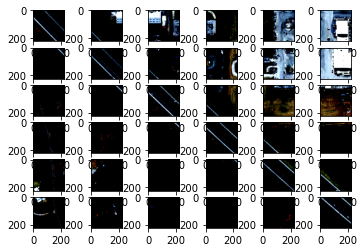

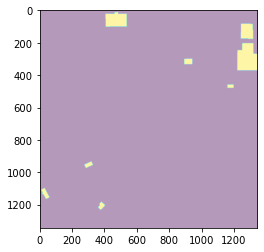

In [25]:
plt.subplot(6, 6, 1)
plt.imshow(dataset1[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 2)
plt.imshow(dataset2[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 3)
plt.imshow(dataset3[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 4)
plt.imshow(dataset4[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 5)
plt.imshow(dataset5[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 6)
plt.imshow(dataset6[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 7)
plt.imshow(dataset7[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 8)
plt.imshow(dataset8[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 9)
plt.imshow(dataset9[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 10)
plt.imshow(dataset10[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 11)
plt.imshow(dataset11[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 12)
plt.imshow(dataset12[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 13)
plt.imshow(dataset13[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 14)
plt.imshow(dataset14[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 15)
plt.imshow(dataset15[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 16)
plt.imshow(dataset16[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 17)
plt.imshow(dataset17[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 18)
plt.imshow(dataset18[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 19)
plt.imshow(dataset19[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 20)
plt.imshow(dataset20[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 21)
plt.imshow(dataset21[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 22)
plt.imshow(dataset22[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 23)
plt.imshow(dataset23[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 24)
plt.imshow(dataset24[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 25)
plt.imshow(dataset25[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 26)
plt.imshow(dataset26[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 27)
plt.imshow(dataset27[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 28)
plt.imshow(dataset28[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 29)
plt.imshow(dataset29[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 30)
plt.imshow(dataset30[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 31)
plt.imshow(dataset31[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 32)
plt.imshow(dataset32[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 33)
plt.imshow(dataset33[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 34)
plt.imshow(dataset34[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 35)
plt.imshow(dataset35[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.subplot(6, 6, 36)
plt.imshow(dataset36[0][0].cpu().numpy().transpose((1, 2, 0)))
plt.show()
plt.imshow(dataset[0][1], alpha=0.4)
plt.show()

In [ ]:
dataset = dataset1 + dataset2+dataset3+dataset4+dataset5
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
len(dataloader) * 128

114304

In [20]:
import torch.nn as nn
import torchvision.models

## Define Model

In [21]:
import torchvision.models as models

def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

In [15]:
import torch
import torch.nn as nn
import torchvision
resnet = torchvision.models.resnet.resnet50(pretrained=True)


class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """

        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=1):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

## Model Train

In [ ]:
model

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 512, 512))

In [13]:
import warnings

# 경고 메시지 무시 설정
warnings.filterwarnings("ignore")

In [25]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
params = [ p.requires_grad 인 경우 model.parameters() 의 p 에 대한 p ] 옵티마이저 = torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay) lr_scheduler = torch.optim.lr_scheduler.StepLR(옵티마이저 , step_size= 5 , 감마= 0.1 ) n_batches = 길이 (dl_train)



In [32]:
# model 초기화

#model = ResNetUNet(1)
model = UNetWithResnet50Encoder()
model = nn.DataParallel(model,device_ids = [0,1,2,3])
model.to(device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# training loop
for epoch in range(2):  # 10 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        #lr_scheduler.step()
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')

100%|██████████| 4589/4589 [1:00:03<00:00,  1.27it/s]


Epoch 1, Loss: 0.09799736491908796


100%|██████████| 4589/4589 [55:54<00:00,  1.37it/s] 

Epoch 2, Loss: 0.04937613509655466


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [27]:
epoch = 8
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, './model(divide=36,b=64,resnetunet,8).pth')

In [26]:
model = UNetWithResnet50Encoder()
model = nn.DataParallel(model,device_ids = [0,1,2,3,4,5])
model.to(device)

checkpoint = torch.load('./model(divide=36,b=64,resnetunet,6).pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

for epoch in range(2):  # 10 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')

100%|██████████| 4589/4589 [1:05:53<00:00,  1.16it/s]


Epoch 1, Loss: 0.047403771373428896


100%|██████████| 4589/4589 [1:03:19<00:00,  1.21it/s]

Epoch 2, Loss: 0.047267437009207824


In [29]:
import torch

# 학습된 모델을 model 변수에 할당한 후 저장
torch.save(model, './model(adv-10-64-0.0001).pth')
#totalrr10 배치사이즈 16 0.0001 25장 10번 에포크

In [ ]:
model = UNetWithResnet50Encoder()
model = nn.DataParallel(model,device_ids = [0,1,2,3])
model.to(device)

checkpoint = torch.load('./model(b=64,resnetunet,15).pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [20]:
torch.save(model.state_dict(), 'model-con.pt')

In [35]:
import torch
model = torch.load("./model(epoch12).pt", map_location=device)

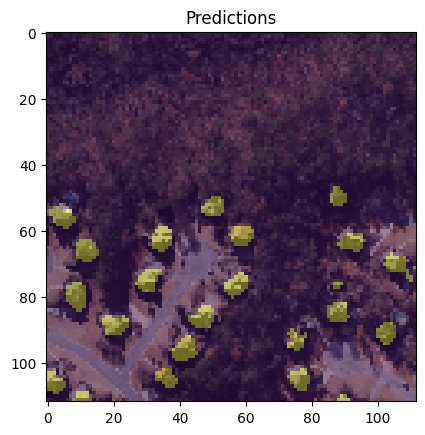

In [ ]:
# train 시각화 함수
import matplotlib.pyplot as plt

def analyze_train_sample(model, ds_train, sample_index=10):

    # sample image

      for img in ds_train:
        model.eval()
        with torch.no_grad():
            #print(img[0][:112,:112])
            img= img[0].float().to(device)
            preds = model(img)
            #print(preds[0][0][:112,:112])
        #print(img[0])
        tmp = dataset2[1][0] / 255.0
        #print(tmp)
        plt.imshow(tmp[:112,:112].cpu().numpy().transpose((1, 2, 0)))
        masks = torch.sigmoid(preds[1][0][:112,:112]).cpu().numpy()
        #masks = np.squeeze(masks, axis=1)
        #print(masks)
        masks = masks >0.5
        plt.imshow(masks, alpha=0.4)
        plt.title('Predictions')
        plt.show()
        break
      return preds


sample_vi = analyze_train_sample(model, dataloader, 1)

In [ ]:
# train 시각화 함수
import matplotlib.pyplot as plt

def analyze_train_sample(model, ds_train, sample_index=10):

    # sample image

      for img in ds_train:
        model.eval()
        with torch.no_grad():
            #print(img)
            img= img.float().to(device)
            preds = model(img)
        plt.imshow(img[7].cpu().numpy().transpose((1, 2, 0)))
        masks = torch.sigmoid(preds[7][0]).cpu().numpy()
        #masks = np.squeeze(masks, axis=1)
        #print(masks)
        masks = masks >0.5
        plt.imshow(masks, alpha=0.4)
        plt.title('Predictions')
        plt.show
        break
      return preds


sample_vi = analyze_train_sample(model, test_dataloader, 20)

In [34]:
with torch.no_grad():
    model.eval()
    result = []
    for images, mask in tqdm(valid_dataloader):
        images = images.float().to(device)

        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.4).astype(np.uint8) # Threshold = 0.35

        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

  0%|          | 0/191 [00:53<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 4; 9.78 GiB total capacity; 79.90 MiB already allocated; 4.44 MiB free; 86.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

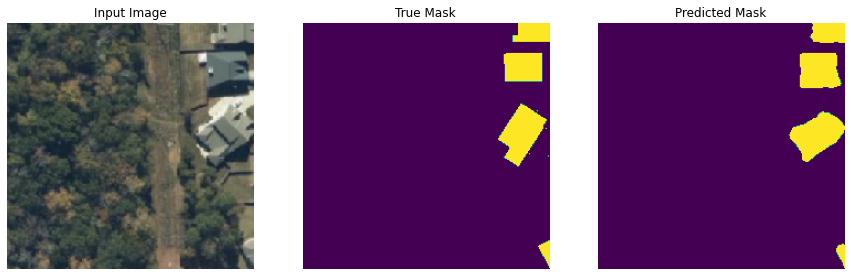

In [25]:
import matplotlib.pyplot as plt

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0:
            img = cv2.imread(display_list[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.uint8).copy()
        if i == 1:
            img = cv2.imread(display_list[i], 0)
        if i == 2:
            img = rle_decode(display_list[i], shape = (224, 224)) # shape 설정

        plt.imshow(img)
        plt.axis('off')
    plt.show()

idx = 3

valid_img_path_idx = valid_img_dir + df_valid['img_path'][idx]
valid_mask_path_idx = valid_mask_dir + df_valid['mask_path'][idx]
valid_pred_mask_idx = result[idx]

display_list = [valid_img_path_idx, valid_mask_path_idx, valid_pred_mask_idx]
display(display_list)

In [26]:
import numpy as np
import pandas as pd
from typing import List, Union
from joblib import Parallel, delayed


def rle_decode(mask_rle: Union[str, int], shape=(224, 224)) -> np.array:
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    if mask_rle == -1:
        return np.zeros(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [27]:
def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7) -> float:
    '''
    Calculate Dice Score between two binary masks.
    '''
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)


def calculate_dice_scores(ground_truth_df, prediction_df, img_shape=(224, 224)) -> List[float]:
    '''
    Calculate Dice scores for a dataset.
    '''


    # Keep only the rows in the prediction dataframe that have matching img_ids in the ground truth dataframe
    prediction_df = prediction_df[prediction_df.iloc[:, 0].isin(ground_truth_df.iloc[:, 0])]
    prediction_df.index = range(prediction_df.shape[0])


    # Extract the mask_rle columns
    pred_mask_rle = prediction_df.iloc[:, 1]
    gt_mask_rle = ground_truth_df.iloc[:, 1]


    def calculate_dice(pred_rle, gt_rle):
        pred_mask = rle_decode(pred_rle, img_shape)
        gt_mask = rle_decode(gt_rle, img_shape)


        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None


    dice_scores = Parallel(n_jobs=-1)(
        delayed(calculate_dice)(pred_rle, gt_rle) for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle)
    )


    dice_scores = [score for score in dice_scores if score is not None]  # Exclude None values


    return np.mean(dice_scores)

In [28]:
valid_pred = {'mask_rle': result}
prediction_df = pd.DataFrame(data = valid_pred)


lst_ground_truth_rle = [rle_encode((validset.__getitem__(i))[1]) for i in range(len(df_valid))]
valid_pred = {'mask_rle': lst_ground_truth_rle}
ground_truth_df = pd.DataFrame(data = valid_pred)

In [33]:
import tensorflow as tf
from tensorflow import keras
from keras.metrics import MeanIoU
from matplotlib import pyplot as plt
import tifffile as tiff
from PIL import Image
import random

In [34]:
calculate_dice_scores(ground_truth_df, prediction_df, img_shape=(224, 224))

IndexError: single positional indexer is out-of-bounds

In [30]:
predNoBuildingIdx = list(filter(lambda x: result[x] == -1, range(len(result))))

In [31]:
from sklearn.metrics import confusion_matrix

def generateConfusionMatrix(ground_truth_mask, pred_mask):
    y_true = sum(rle_decode(ground_truth_mask).tolist(), [])
    y_pred = sum(rle_decode(pred_mask).tolist(), [])
    cMatrix = confusion_matrix(y_true, y_pred)
    return cMatrix

def generateConfusionMatrixLst(lst_ground_truth_rle, lst_pred_rle):
    lst_cMatrix = Parallel(n_jobs=1)(delayed(generateConfusionMatrix)(lst_ground_truth_rle[i], result[i]) for i in range(len(lst_ground_truth_rle)))
    return lst_cMatrix

In [32]:
Lst_cMatrix = generateConfusionMatrixLst(lst_ground_truth_rle, result)

In [35]:
def IoU(cMatrix):
    Intersection = cMatrix.diagonal()
    Union11 = cMatrix.sum(axis = 0)[0] + cMatrix[0][1]
    Union22 = cMatrix.sum(axis = 0)[1] + cMatrix[1][0]
    Union = np.array([Union11, Union22])
    return Intersection / Union

# 전체 이미지 IoU 수치에 대하여 평균냄.
def totalIoU(lst_cMatrix):
    totalIoU = np.array([0, 0], dtype = 'float64')
    for cMat in lst_cMatrix:
        totalIoU += IoU(cMat)
    return totalIoU / len(lst_cMatrix)

def eachIoU(lst_cMatrix):
    eachIoU = []
    for cMat in lst_cMatrix:
        eachIoU.append(IoU(cMat))
    return eachIoU

In [36]:
totaliou = totalIoU(Lst_cMatrix)

In [37]:
def printClassScores(totaliou):
    label = ['background', 'building']
    print('classes          IoU      nIoU')
    print('--------------------------------')
    for i, iou in enumerate(totaliou):
        labelName = label[i]
        iouStr = f'{iou:>5.3f}'
        niouStr = 'empty'
        print('{:<14}: '.format(labelName) + iouStr + '    ' + niouStr)
    print('--------------------------------')
    print(f'Score Average : {(np.sum(totaliou) / 2):>5.3f}' + '    ' + niouStr)

In [38]:
printClassScores(totaliou)

classes          IoU      nIoU
--------------------------------
background    : 0.964    empty
building      : 0.762    empty
--------------------------------
Score Average : 0.863    empty


## Inference

In [28]:
transform3 = A.Compose(
    [
        A.Resize(224,224),
        A.Normalize(),
        ToTensorV2()
    ]
)

In [30]:
test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform3, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=48)

In [ ]:
test_dataset[0]

<ipython-input-23-f5cfe5d6baaa>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32) / 255.0


tensor([[[0.6980, 0.7020, 0.7020,  ..., 0.5765, 0.5765, 0.5882],
         [0.7059, 0.7098, 0.7098,  ..., 0.5922, 0.6078, 0.6314],
         [0.7137, 0.7137, 0.7098,  ..., 0.5765, 0.5882, 0.6078],
         ...,
         [0.6745, 0.6667, 0.6706,  ..., 0.7333, 0.7451, 0.6588],
         [0.6745, 0.6784, 0.6784,  ..., 0.7608, 0.7216, 0.6471],
         [0.6784, 0.6784, 0.6824,  ..., 0.7569, 0.7216, 0.6353]],

        [[0.6549, 0.6588, 0.6588,  ..., 0.5176, 0.5176, 0.5294],
         [0.6627, 0.6667, 0.6667,  ..., 0.5373, 0.5529, 0.5765],
         [0.6706, 0.6706, 0.6667,  ..., 0.5255, 0.5373, 0.5569],
         ...,
         [0.6549, 0.6431, 0.6392,  ..., 0.7176, 0.7255, 0.6471],
         [0.6392, 0.6353, 0.6314,  ..., 0.7255, 0.6902, 0.6157],
         [0.6392, 0.6353, 0.6353,  ..., 0.7216, 0.6902, 0.6039]],

        [[0.7176, 0.7216, 0.7216,  ..., 0.5059, 0.5059, 0.5176],
         [0.7255, 0.7294, 0.7294,  ..., 0.5176, 0.5333, 0.5569],
         [0.7333, 0.7333, 0.7294,  ..., 0.4980, 0.5098, 0.

In [31]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs = model(images)
        #print(outputs)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.4).astype(np.uint8) # Threshold = 0.35
        #print(masks)
        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            #print(mask_rle)
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

100%|██████████| 948/948 [06:42<00:00,  2.35it/s]


## Submission

In [32]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

In [33]:
submit.to_csv('./submit(resnetunet-adv-25-8).csv', index=False)